In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from utils import reduce_mem_usage, save_submission, plot_confusion_matrix

plt.style.use('seaborn-darkgrid')

%matplotlib inline

In [2]:
test = pd.read_csv('../input/ion-switching-3-feature-engineering/test_features.csv')
train = pd.read_csv('../input/ion-switching-3-feature-engineering/train_features.csv')

In [4]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Mem. usage decreased to 435.35 Mb (67.6% reduction)
Mem. usage decreased to 156.40 Mb (66.9% reduction)


In [5]:
X, y = train.drop(['open_channels'], axis=1).values, train['open_channels'].values

In [6]:
import pickle

from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold

scores = []

n_splits = 5
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)
for i, (train_idx, val_idx) in enumerate(cv.split(X, y)):
    
    X_train, y_train = X[train_idx], y[train_idx]
    X_val, y_val = X[val_idx], y[val_idx]
    
    lgbm = LGBMClassifier(n_estimators=70,
                         learning_rate=0.03,
                         reg_lambda=0.3,
                         reg_alpha=1.5,
                         max_depth=25,
                         num_leaves=135)
    
    lgbm.fit(X_train, y_train)
    
    preds = lgbm.predict(X_val)
    
    score = f1_score(y_val, preds, average='macro')
    scores.append(score)
    
    print(f'CV round {i + 1} score: {score: .5f}')
    
    with open(f'lgbm-cv-round-{i + 1}', 'wb') as f:
        pickle.dump(lgbm, f)
        
        
print(f'CV mean score: {np.array(scores).mean(): .5f}')

CV round 1 score:  0.93999
CV round 2 score:  0.94010
CV round 3 score:  0.94067
CV round 4 score:  0.94002
CV round 5 score:  0.94031
CV mean score:  0.94022


  0%|          | 0/5 [00:00<?, ?it/s]

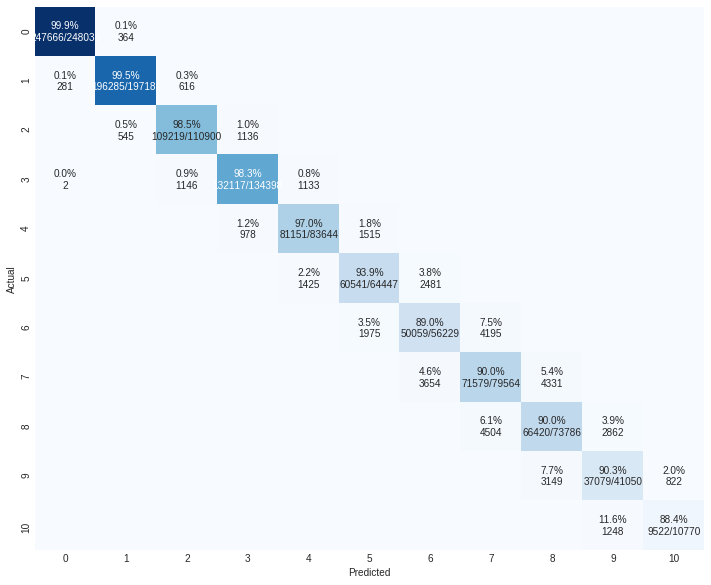

In [9]:
from tqdm.notebook import tqdm

files = [f'lgbm-cv-round-{i + 1}' for i in range(n_splits)]

proba = []
for f in tqdm(files):
    with open(f, 'rb') as _f:
        lgbm = pickle.load(_f)
        
    preds = lgbm.predict_proba(X_val)
    proba.append(preds)
    
proba = np.array(proba).mean(axis=0)
preds = np.argmax(proba, axis=1)

plot_confusion_matrix(y_val, preds)

In [10]:
files = [f'lgbm-cv-round-{i + 1}' for i in range(n_splits)]

proba = []
for f in tqdm(files):
    with open(f, 'rb') as _f:
        lgbm = pickle.load(_f)
        
    preds = lgbm.predict_proba(test)
    proba.append(preds)
    
proba = np.array(proba).mean(axis=0)
preds = np.argmax(proba, axis=1)

save_submission(preds, 'lgbm')

  0%|          | 0/5 [00:00<?, ?it/s]

# Pseudo-labelling

In [11]:
test_labels = pd.read_csv('./lgbm_submission.csv')

test['open_channels'] = test_labels['open_channels']

sample = test.sample(frac=0.2)
test.drop('open_channels', axis=1, inplace=True)

In [12]:
train = pd.concat([train, sample])
X, y = train.drop('open_channels', axis=1), train['open_channels']

In [13]:
lgbm = LGBMClassifier(n_estimators=70,
                     learning_rate=0.03,
                     reg_lambda=0.3,
                     reg_alpha=1.5,
                     max_depth=25,
                     num_leaves=135)

lgbm.fit(X, y)

preds = lgbm.predict(test)

with open('lgbm-pseudo-labelled-classifier.pkl', 'wb') as f:
    pickle.dump(lgbm, f)

save_submission(preds, 'lgbm-pseudo-labelled')

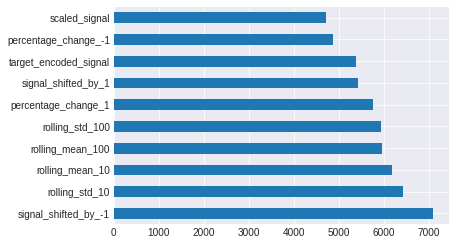

In [14]:
feature_importances = lgbm.feature_importances_
feature_importances = pd.Series(feature_importances, index=test.columns)
feature_importances.sort_values(inplace=True, ascending=False)
feature_importances[:10].plot.barh()
plt.show()